In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import defaultdict
import cv2
import matplotlib.pyplot as plt
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

for dirname, _, filenames in os.walk('/kaggle/input/cmp23-handwritten-males-vs-females'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

In [ ]:
def get_files_paths(paths):
    ret = []
    for path in paths:
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                ret.append(os.path.join(dirname, filename))
    return ret

In [ ]:
# return chaincodes as list of strings
def chaincodes_from_contours(contours):
    # dx, dy -> direction
    dir = [['0', '1', '2'],
           ['7', '9', '3'],
           ['6', '5', '4']]

#     print(contours)
    conts = ['']*len(contours)
    for idx in range(len(contours)):
        for i in range(len(contours[idx])-1):
#             print( (contours[idx][i+1]))
            dx, dy = (contours[idx][i+1] - contours[idx][i])[0]
            dx += 1
            dy += 1
            conts[idx] += dir[dy][dx]
    return conts

In [ ]:
# pdf of chain code from images!
# [idx][code]
# [idx]['1'] -> pdf of ['1']
# [idx]['01'] -> pdf of ['01']
# [idx]['345'] -> pdf of['345']
def chaincodes_from_images(images, th1 = 100000, th2 = 1000):
    chaincodes = [[]] * len(images)
    for idx in range(len(images)):
        img = cv2.imread(images[idx])
        imgh, imgw = len(img), len(img[0])
        imgarea = imgh * imgw
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        
        ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_OTSU)

#         plt.imshow(img)
#         plt.show()
        
#         plt.imshow(thresh)
#         plt.show()
        
        # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
        contours, _ = cv2.findContours(image=thresh, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE)
        contours_filt = list(filter(lambda cnt: imgarea/th1 <= cv2.contourArea(cnt) <= imgarea/th2, contours))
        
#         img2 = img.copy()
#         cv2.drawContours(img2, contours_filt, -1, (0,255,0), 3)
#         plt.imshow(img2)
#         plt.show()
        
        chaincodes[idx] = chaincodes_from_contours(contours_filt)
    
    return chaincodes

In [ ]:
def pdf_from_chaincodes(chaincodes, length):
    # print(length)
    pdf = [defaultdict(lambda: 0, {}) for _ in range(length+1)]
    
    # print(1, pdf[0]['6']) 
    # print(1, pdf[1]['6']) 
    # print(1, pdf[2]['6']) 

    # calc freq of all substrings with length
    for leng in range(1, length+1):
        for cnt in chaincodes:
            for i in range(len(cnt) - leng):
                pdf[leng][cnt[i: i+leng]] += 1
    return pdf

In [ ]:
def probalize(bad_pdf):
    try:
        a = {key: value/sum(bad_pdf.values()) for key, value in bad_pdf.items()}
        return defaultdict(lambda: 0, a)
    except:
        a = {}
        return defaultdict(lambda: 0, a) # empty dict, avoid div by zero

In [ ]:

def gen_labels(labels, LENGTH = 3, curr = ''):
    if (len(curr)):
        labels.append(curr)

    if len(curr) < LENGTH:
        for i in range(0, 8):
            gen_labels(labels, LENGTH, curr + str(i))
    return

In [ ]:
def get_chaincode_feature_from_img(img_path, th1 = 100000, th2 = 1000, MAX_CHAINCODE_LENGTH = 3, debug = False):

    chaincodes = chaincodes_from_images(images=[img_path], th1=th1, th2=th2)[0]
    pdfs = pdf_from_chaincodes(chaincodes=chaincodes, length=MAX_CHAINCODE_LENGTH)
    pdfs_n = [probalize(pdf) for pdf in pdfs]

    
    # generate all labels to fix order of features
    labels = []
    gen_labels(labels, MAX_CHAINCODE_LENGTH)
    if debug:
        count = sum([8**i for i in range(1, MAX_CHAINCODE_LENGTH+1)])
        print(f'Generating pdf for {count} chaincodes')
        print(labels[0:30], '...')
        assert len(labels) == count

    # fix order!
    pdfs_combined = {label: 0 for label in labels}
    if debug:
        print(list(pdfs_combined.items())[0:30])
    # join all pdfs
    for pdf in pdfs_n:
        pdfs_combined.update(pdf)

    
    feature_vec = [pdfs_combined[label] for label in labels]

    return feature_vec



In [164]:
def test_one_image(images = females, idx = 0, MAX_CHAINCODE_LENGTH = 3):
    x_axis = []
    gen_labels(x_axis, LEN)
    y_axis = get_chaincode_feature_from_img(females[0], MAX_CHAINCODE_LENGTH=MAX_CHAINCODE_LENGTH, debug=True)
    
    print('Features of this image')
    plt.rcParams["figure.figsize"] = (17, 6)
    plt.plot(x_axis, y_axis, 'b.')

In [162]:
def test_all_images(
        males_paths=['../Training Dataset/CMP_23/Males'],
        females_paths=['../Training Dataset/CMP_23/Females'],
        MAX_CHAINCODE_LENGTH=3,
        th1=100000,
        th2=1000):

    # add icdar when ready
    males = get_files_paths(males_paths)
    females = get_files_paths(females_paths)
    males_num = len(males)
    females_num = len(females)

    print(f'Testing on {males_num} male, & {females_num} female, pictures')

    female_vecs = [get_chaincode_feature_from_img(
        female, MAX_CHAINCODE_LENGTH=MAX_CHAINCODE_LENGTH) for female in females]
    male_vecs = [get_chaincode_feature_from_img(
        male, MAX_CHAINCODE_LENGTH=MAX_CHAINCODE_LENGTH) for male in males]

    # print(len(female_vecs))
    # print(len(female_vecs[0]))

    print(f'female vecs first 5 values for first images: {female_vecs[0][:5]}')
    print(f'male vecs first 5 vaules for first images]: {male_vecs[0][:5]}')

    # sum columns
    female_vec = np.sum(female_vecs, axis=0) / females_num
    male_vec = np.sum(male_vecs, axis=0) / males_num

    print(f'len(female_vec): {len(female_vec)}')
    print(f'female vec[:2]: {female_vec[:2]}')
    print(f'male vec[:2]: {male_vec[:2]}')

    x_axis = []
    gen_labels(x_axis, MAX_CHAINCODE_LENGTH)

    dat = [(x_axis[idx], female_vec[idx] - male_vec[idx])
           for idx in range(len(x_axis))]
    print(f'unsorted differnce dat[:5]: {dat[:5]}')

    dat = sorted(dat, key=lambda x: abs(x[1]), reverse=True)[:30]

    plt.rcParams["figure.figsize"] = (17, 6)
    x_axis, y_axis = list(zip(*dat))
    plt.plot(x_axis, y_axis, 'b.')
    plt.show()


Generating pdf for 584 chaincodes
['0', '00', '000', '001', '002', '003', '004', '005', '006', '007', '01', '010', '011', '012', '013', '014', '015', '016', '017', '02', '020', '021', '022', '023', '024', '025', '026', '027', '03', '030'] ...
[('0', 0), ('00', 0), ('000', 0), ('001', 0), ('002', 0), ('003', 0), ('004', 0), ('005', 0), ('006', 0), ('007', 0), ('01', 0), ('010', 0), ('011', 0), ('012', 0), ('013', 0), ('014', 0), ('015', 0), ('016', 0), ('017', 0), ('02', 0), ('020', 0), ('021', 0), ('022', 0), ('023', 0), ('024', 0), ('025', 0), ('026', 0), ('027', 0), ('03', 0), ('030', 0)]


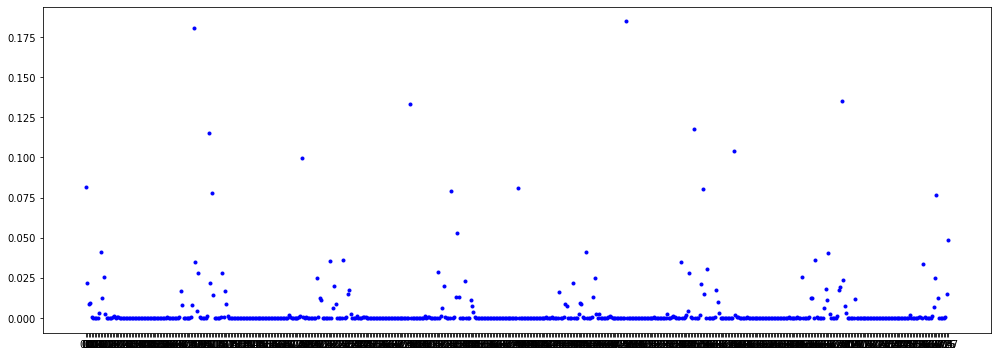

In [160]:
test_one_image()

Testing on 232 male, & 131 female, pictures
female vecs first 5 values for first images: [0.08157253724579391, 0.021602648250670625, 0.008798665823221577, 0.009258726781298523, 0.0004888147679567542]
male vecs first 5 vaules for first images]: [0.09821629599979986, 0.02710668849981106, 0.012152117106832078, 0.00938681279650912, 0.00045665575766801127]
len(female_vec): 584
female vec[:2]: [0.07646571 0.02352135]
male vec[:2]: [0.07247354 0.02225146]
unsorted differnce dat[:5]: [('0', 0.003992174350121849), ('00', 0.0012698954194037895), ('000', 0.0005708211658316219), ('001', 6.0291857521403355e-05), ('002', 3.4627279588616763e-06)]


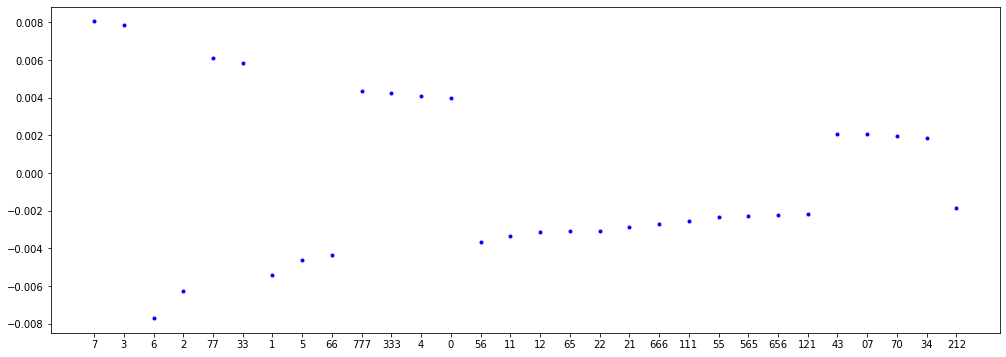

In [163]:
test_all_images()